In [22]:
import glob
import pickle
import numpy as np
import scipy
import skimage.morphology
import skimage.transform
from sklearn.model_selection import train_test_split
from io import StringIO
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import warnings
from sklearn.neural_network import MLPClassifier
import csv
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

# where is the data relative to current directory
REL_PATH = os.path.join(".","data","isolatedTest2014")

# where are we saving the outputs to
TRUTH_FILE = os.path.join(REL_PATH, "iso_GT.txt")
DUMP_LOCATION = os.path.join(".","pickle_files")
SAVE_FILENAME = os.path.join(DUMP_LOCATION,"raw_symbols.p")

NORMALIZED_IMAGE_SHAPE = (50,50)

def normalize_coordinates(coords, maintain_ar = False):
    min_x = np.min(coords[:,0])
    min_y = np.min(coords[:,1])
    max_x = np.max(coords[:,0])
    max_y = np.max(coords[:,1])
    
    normalized = coords.copy()
    normalized[:,0] = normalized[:,0] - min_x
    normalized[:,1] = normalized[:,1] - min_y
    
    return normalized


def coords_to_image(coords, clean=True):
    normalized = normalize_coordinates(coords)
    
    M = np.max(normalized[:,0]) + 1
    N = np.max(normalized[:,1]) + 1
    
    image = np.zeros((M,N))
        
    for coord in normalized:
        image[coord[0],coord[1]] = 1

    return image.transpose((1,0))

def clean_image(image):
    diff = 5
    image = np.pad(image, diff, mode='constant', constant_values=(0,0))
    image = skimage.transform.resize(image, NORMALIZED_IMAGE_SHAPE)
    return image
    
def stroke_to_arr(stroke):
    stroke = stroke.replace(',', '\n')
    stroke_IO = StringIO(stroke)
    stroke_arr = np.loadtxt(stroke_IO)
    return stroke_arr

def parse_meta(inkml_file):
    tree = ET.parse(inkml_file)
    root = tree.getroot()
    
    annotation = root.find("{http://www.w3.org/2003/InkML}annotation")
    return annotation.text
    
def parse_traces(inkml_file):
    tree = ET.parse(inkml_file)
    root = tree.getroot()
    traces = root.findall("{http://www.w3.org/2003/InkML}trace")
    d_traces = []
    for trace in traces:
        d_trace = stroke_to_arr(trace.text)
        if(len(d_trace.shape)==1):
            d_trace = d_trace.reshape(1,d_trace.shape[0])
        d_traces.append(d_trace)
    return np.array(d_traces)

def inkml_to_image(inkml_file):
    traces = parse_traces(inkml_file)
    image_id = parse_meta(inkml_file)
    coords = []
    for trace in traces:
        coords.extend(trace)
    coords = np.array(coords)
    return image_id, clean_image(coords_to_image(coords,False))

def image_to_input(image):
    return image.flatten()

def input_to_image(X):
    return X.reshape(NORMALIZED_IMAGE_SHAPE)

def build_data_dicts():
    symbol_dict = {}
    image_dict = {}
    input_dict = {}

    with open(TRUTH_FILE, "rt") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            symbol_dict[str(row[0])] = row[1]

    inkml_files = glob.glob(os.path.join(REL_PATH,"*.inkml"))
    for inkml_file in tqdm(inkml_files):
        image_id, image = inkml_to_image(inkml_file)
        symbol = symbol_dict[str(image_id)] 
        if(symbol!='junk' and symbol!=' junk'):
            input_image = image_to_input(image)
            input_dict[image_id] = input_image  
            
    return input_dict, symbol_dict

def dict_to_list(X, y):
    X_list = []
    y_list = []
    for image_id, value in X.items():
        X_list.append(X[image_id])
        y_list.append(y[image_id])
    return X_list, y_list

def train_mlp(X, y, verbose=False):

    if(isinstance(X, dict)):
        X_list = []
        y_list = []
        for key, value in X.iteritems():
            X_list.append(X[key])
            y_list.append(y[key])
        X = X_list
        y = y_list


    mlp = MLPClassifier(verbose=verbose)
    mlp.fit(X, y)
    return mlp

model_file_names = {1: './pickle_files/mlp1.p'} 
input_file_names = {1:'./pickle_files/input1.p'}
output_file_names = {1:'./pickle_files/output1.p'}

def get_model(version=1):
    return joblib.load(model_file_names[version])

def get_input(version=1):
    return joblib.load(input_file_names[version])

def get_output(version=1):
    return joblib.load(output_file_names[version])

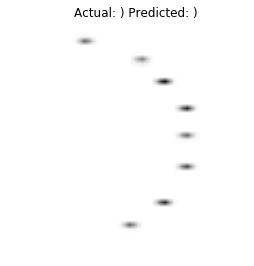

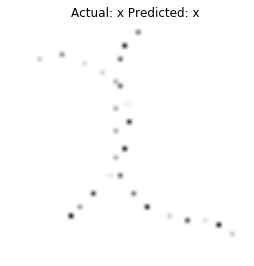

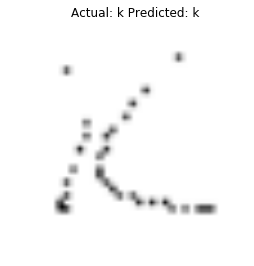

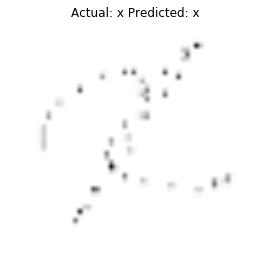

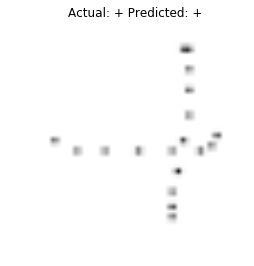

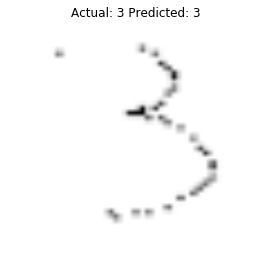

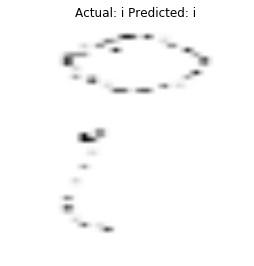

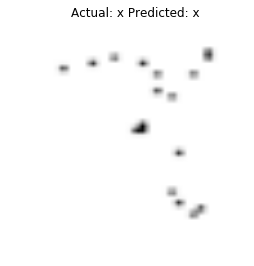

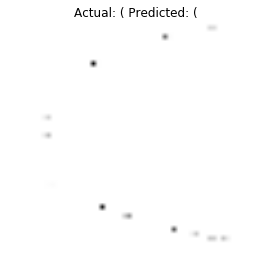

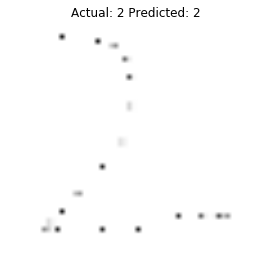

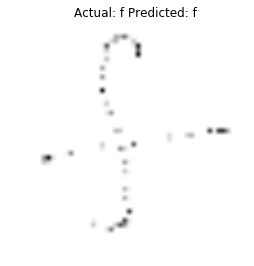

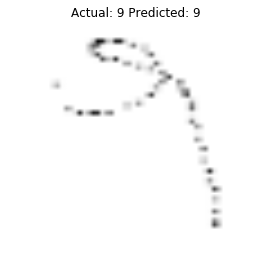

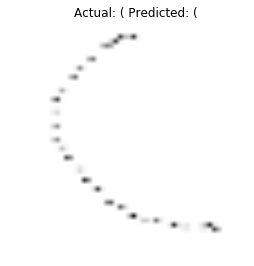

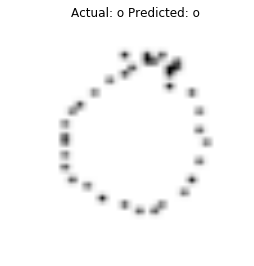

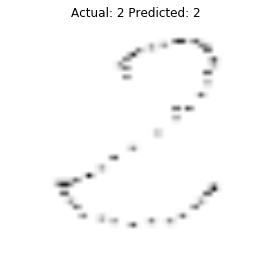

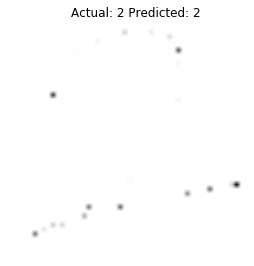

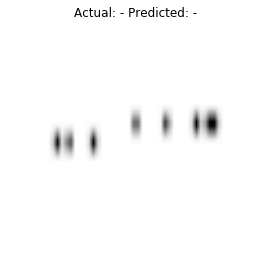

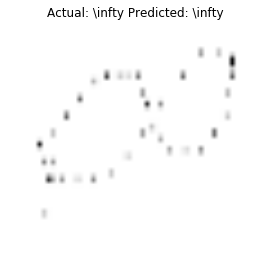

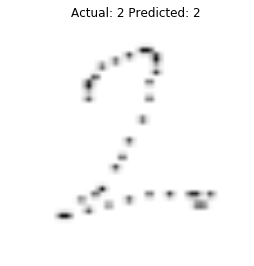

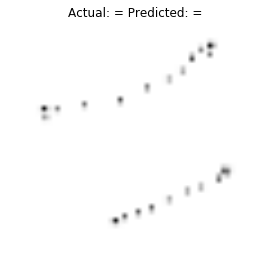

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

VERSION = 1

clf = tools.get_model(VERSION)
X = tools.get_input(VERSION)
y = tools.get_output(VERSION)

for input_image,symbol in zip(X[0:20],y[0:20]):
    image = tools.input_to_image(input_image)
    plt.imshow(image, cmap="Greys")
    plt.axis('off')
    plt.title("Actual: " + symbol + " Predicted: " + str(clf.predict(input_image)[0]))
    plt.show()